In [1]:
#!pip install datatable
#!pip install pycaret

In [2]:
import pandas as pd
import datatable as dt 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
monthyear = 'feb2022'

In [5]:
raw = pd.read_feather("../content/drive/MyDrive/RAFI/Fraud Detection/Data Sources/" + monthyear + "deposit.feather")

In [6]:
raw.head()

,Transaction ID,Client ID,Branch,First Name,Middle Name,Last Name,Street,Village,City,State,...,Reference Number,Transaction Amount,Service Fee,Loan Amount,Total Loan Outstanding (OLB),Deposit Balance,Interest,Principal,Penalty,Fee
0,55179105,0240012770,Ormoc 1 - Main,Gemma,Nazario,Dela Cruz,Puroksantol,Ormoc 1,,,...,86014,50.00,,,,4229.32,,,,
1,55179104,0240012099,Ormoc 1 - Main,Rosalina,Agsie,Salazar,Purok2,BANTIGUE,ORMOC,LEYTE,...,86017,83.00,,,,11144.82,,,,
2,55179059,0240013073,Ormoc 1 - Main,Geneline,Pening,Formentera,Batuan,BATUAN,ORMOC,LEYTE,...,85637,50.00,,,,4382.66,,,,
3,55179058,0240012666,Ormoc 1 - Main,Emelie,Joyo,Manza,CAMPDOWNES,CAMPDWONES,ORMOC,LEYTE,...,85927,53.00,,,,3693.69,,,,
4,55179016,0240012290,Ormoc 1 - Main,Marilyn,Repollo,Laurente,Purok 6,Ormoc 1,,,...,85621,50.00,,,,4293.32,,,,


In [7]:
raw = raw[raw['Transaction ID'] != 'Records from date:']

In [8]:
raw['Transaction Type'].value_counts()

Deposit    921728
Name: Transaction Type, dtype: int64

In [9]:
raw["Transaction Amount"] = pd.to_numeric(raw["Transaction Amount"], errors='coerce')
raw["Service Fee"] = pd.to_numeric(raw["Service Fee"], errors='coerce')
raw["Loan Amount"] = pd.to_numeric(raw["Loan Amount"], errors='coerce')
raw["Total Loan Outstanding (OLB)"] = pd.to_numeric(raw["Total Loan Outstanding (OLB)"], errors='coerce')
raw["Deposit Balance"] = pd.to_numeric(raw["Deposit Balance"], errors='coerce')
raw["Interest"] = pd.to_numeric(raw["Interest"], errors='coerce')
raw["Principal"] = pd.to_numeric(raw["Principal"], errors='coerce')
raw["Penalty"] = pd.to_numeric(raw["Penalty"], errors='coerce')
raw["Fee"] = pd.to_numeric(raw["Fee"], errors='coerce')
raw['Entry Time'] = raw['Entry Time'].astype('datetime64[ns]')
raw['Transaction Date'] = raw['Transaction Date'].astype('datetime64[ns]')

In [10]:
# Extract Time and Weekday
raw['Entry Hour'] = raw['Entry Time'].dt.hour
raw['Entry Day'] = raw['Entry Time'].dt.strftime("%A")

In [11]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 921728 entries, 0 to 921727
Data columns (total 36 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   Transaction ID                921728 non-null  object        
 1   Client ID                     921728 non-null  object        
 2   Branch                        921728 non-null  object        
 3   First Name                    921728 non-null  object        
 4   Middle Name                   921684 non-null  object        
 5   Last Name                     921728 non-null  object        
 6   Street                        919563 non-null  object        
 7   Village                       921488 non-null  object        
 8   City                          921365 non-null  object        
 9   State                         921728 non-null  object        
 10  Country                       921728 non-null  object        
 11  Client Type  

In [12]:
raw.describe()

,Transaction Amount,Service Fee,Loan Amount,Total Loan Outstanding (OLB),Deposit Balance,Interest,Principal,Penalty,Fee,Entry Hour
count,921728.000000,0.0,0.0,0.0,9.217280e+05,0.0,0.0,0.0,0.0,921728.000000
mean,85.809822,NaN,NaN,NaN,2.585186e+03,NaN,NaN,NaN,NaN,14.257163
std,329.383748,NaN,NaN,NaN,3.962094e+03,NaN,NaN,NaN,NaN,2.086299
min,0.010000,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,0.000000
25%,50.000000,NaN,NaN,NaN,1.009233e+03,NaN,NaN,NaN,NaN,13.000000
50%,50.000000,NaN,NaN,NaN,1.865100e+03,NaN,NaN,NaN,NaN,14.000000
75%,50.000000,NaN,NaN,NaN,3.131593e+03,NaN,NaN,NaN,NaN,15.000000
max,200000.000000,NaN,NaN,NaN,1.000151e+06,NaN,NaN,NaN,NaN,23.000000


### Distribution of Raw Data (Population)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


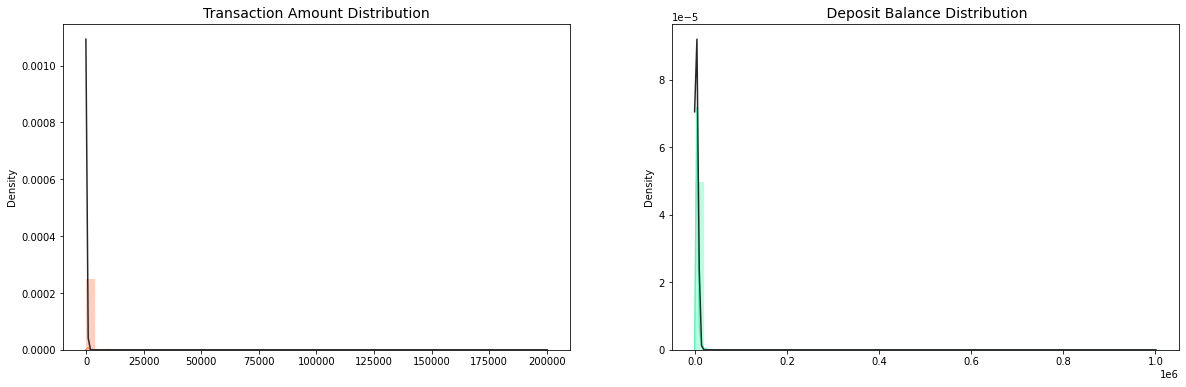

In [13]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 6))

v14_fraud_dist = raw['Transaction Amount'].loc[raw['Transaction Type'] == 'Deposit'].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('Transaction Amount Distribution', fontsize=14)

v12_fraud_dist = raw['Deposit Balance'].loc[raw['Transaction Type'] == 'Deposit'].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title(' Deposit Balance Distribution', fontsize=14)

plt.show()

## Exploratory Data Analysis

In [14]:
df = raw[raw['Transaction Type'] == 'Deposit']

In [15]:
df.head()

,Transaction ID,Client ID,Branch,First Name,Middle Name,Last Name,Street,Village,City,State,...,Service Fee,Loan Amount,Total Loan Outstanding (OLB),Deposit Balance,Interest,Principal,Penalty,Fee,Entry Hour,Entry Day
0,55179105,0240012770,Ormoc 1 - Main,Gemma,Nazario,Dela Cruz,Puroksantol,Ormoc 1,,,...,NaN,NaN,NaN,4229.32,NaN,NaN,NaN,NaN,23,Saturday
1,55179104,0240012099,Ormoc 1 - Main,Rosalina,Agsie,Salazar,Purok2,BANTIGUE,ORMOC,LEYTE,...,NaN,NaN,NaN,11144.82,NaN,NaN,NaN,NaN,23,Saturday
2,55179059,0240013073,Ormoc 1 - Main,Geneline,Pening,Formentera,Batuan,BATUAN,ORMOC,LEYTE,...,NaN,NaN,NaN,4382.66,NaN,NaN,NaN,NaN,23,Saturday
3,55179058,0240012666,Ormoc 1 - Main,Emelie,Joyo,Manza,CAMPDOWNES,CAMPDWONES,ORMOC,LEYTE,...,NaN,NaN,NaN,3693.69,NaN,NaN,NaN,NaN,23,Saturday
4,55179016,0240012290,Ormoc 1 - Main,Marilyn,Repollo,Laurente,Purok 6,Ormoc 1,,,...,NaN,NaN,NaN,4293.32,NaN,NaN,NaN,NaN,23,Saturday


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 921728 entries, 0 to 921727
Data columns (total 36 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   Transaction ID                921728 non-null  object        
 1   Client ID                     921728 non-null  object        
 2   Branch                        921728 non-null  object        
 3   First Name                    921728 non-null  object        
 4   Middle Name                   921684 non-null  object        
 5   Last Name                     921728 non-null  object        
 6   Street                        919563 non-null  object        
 7   Village                       921488 non-null  object        
 8   City                          921365 non-null  object        
 9   State                         921728 non-null  object        
 10  Country                       921728 non-null  object        
 11  Client Type  

In [17]:
df.describe()

,Transaction Amount,Service Fee,Loan Amount,Total Loan Outstanding (OLB),Deposit Balance,Interest,Principal,Penalty,Fee,Entry Hour
count,921728.000000,0.0,0.0,0.0,9.217280e+05,0.0,0.0,0.0,0.0,921728.000000
mean,85.809822,NaN,NaN,NaN,2.585186e+03,NaN,NaN,NaN,NaN,14.257163
std,329.383748,NaN,NaN,NaN,3.962094e+03,NaN,NaN,NaN,NaN,2.086299
min,0.010000,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,0.000000
25%,50.000000,NaN,NaN,NaN,1.009233e+03,NaN,NaN,NaN,NaN,13.000000
50%,50.000000,NaN,NaN,NaN,1.865100e+03,NaN,NaN,NaN,NaN,14.000000
75%,50.000000,NaN,NaN,NaN,3.131593e+03,NaN,NaN,NaN,NaN,15.000000
max,200000.000000,NaN,NaN,NaN,1.000151e+06,NaN,NaN,NaN,NaN,23.000000


We have to exclude Service Fee and Fee because these columns do not have data.

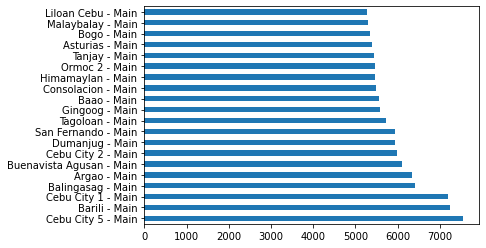

In [18]:
df['Branch'].value_counts()[:20].plot(kind='barh')

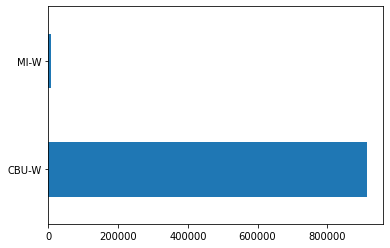

In [19]:
df['Deposit Product ID'].value_counts()[:20].plot(kind='barh')

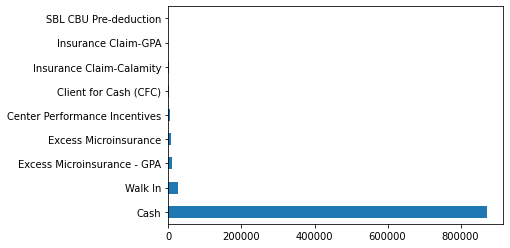

In [20]:
df['Payment Method'].value_counts()[:20].plot(kind='barh')

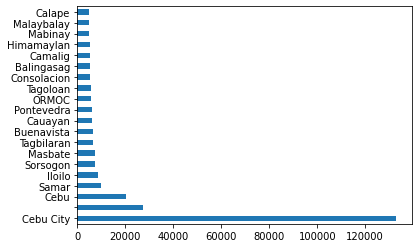

In [21]:
df['City'].value_counts()[:20].plot(kind='barh')

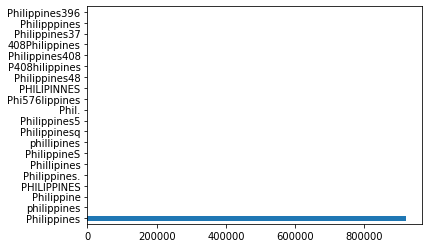

In [22]:
df['Country'].value_counts()[:20].plot(kind='barh')

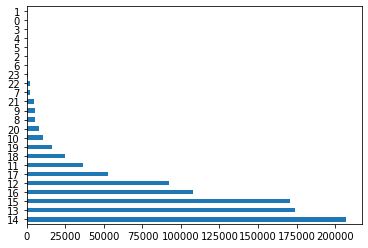

In [23]:
df['Entry Hour'].value_counts().plot(kind='barh')

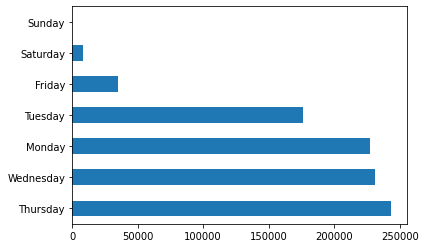

In [24]:
df['Entry Day'].value_counts().plot(kind='barh')

### Sample Size Calculation

Yamane' Formula (working with a finite population and the population size is known):

In [25]:
N = len(df.index)
e = 0.01

In [26]:
yamane = N / (1+N*e**2)
print(yamane)

9892.672539625297


In [27]:
# ceiling for sample size is 10% of the population; the greater the sample size, the better
if (yamane<len(df.index)*8):
    N=len(df.index)*.7
else:
    N=yamane

In [28]:
#df=df.groupby('Branch', group_keys=False).apply(lambda x: x.sample(int(np.rint(N*len(x)/len(df))))).sample(frac=1).reset_index(drop=True)

## Anomaly Detection

In [29]:
df['Transaction Type'].value_counts()

Deposit    921728
Name: Transaction Type, dtype: int64

In [30]:
test = df[['Transaction ID', 'Branch', 'Deposit Product ID', 'Transaction Date',
           'Entry Time', 'Entry Hour', 'Entry Day','Username', 'Payment Method', 'Transaction Amount',
           'Deposit Balance']]

In [ ]:
from pycaret.anomaly import *
s = setup(test,
          normalize=True,
          transformation=True,
         # categorical_features=['Client ID'], 
          ignore_features=['Transaction ID'],
          #combine_rare_levels=True,
          remove_multicollinearity=True,
          session_id = 123)

,Description,Value
0,session_id,123
1,Original Data,"(921728, 11)"
2,Missing Values,False
3,Numeric Features,3
4,Categorical Features,5
5,Ordinal Features,False
6,High Cardinality Features,False
7,High Cardinality Method,None
8,Transformed Data,"(921728, 81)"
9,CPU Jobs,-1


In [ ]:
iforest = create_model('iforest', fraction = 0.05)
iforest_results = assign_model(iforest)
iforest_results.head()

,Transaction ID,Branch,Deposit Product ID,Transaction Date,Entry Time,Entry Hour,Entry Day,Username,Payment Method,Transaction Amount,Deposit Balance,Anomaly,Anomaly_Score
0,55179105,Ormoc 1 - Main,CBU-W,2022-02-05,2022-02-05 23:24:18,23,Saturday,jeme.de.leon,Cash,50.0,4229.32,0,-0.010686
1,55179104,Ormoc 1 - Main,CBU-W,2022-02-05,2022-02-05 23:24:18,23,Saturday,jeme.de.leon,Cash,83.0,11144.82,0,-0.004807
2,55179059,Ormoc 1 - Main,CBU-W,2022-02-05,2022-02-05 23:19:49,23,Saturday,Xernan.Arcuino,Cash,50.0,4382.66,1,0.001723
3,55179058,Ormoc 1 - Main,CBU-W,2022-02-05,2022-02-05 23:19:49,23,Saturday,Xernan.Arcuino,Cash,53.0,3693.69,1,0.000868
4,55179016,Ormoc 1 - Main,CBU-W,2022-02-05,2022-02-05 23:08:07,23,Saturday,Xernan.Arcuino,Cash,50.0,4293.32,1,0.001723


### Learning Curve

In [ ]:
#plot_model(iforest)

### Save Model / Experiment

In [ ]:
# saving model
save_model(iforest, model_name = '/content/drive/MyDrive/RAFI/Fraud Detection/Data Sources/anomaly_detection_deposit_for_deployment' + monthyear)

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True,
                                       features_todrop=['Transaction ID'],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[],
                                       target='UNSUPERVISED_DUMMY_TARGET',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='most frequent',
                                 fill_value_categorical=None,
                                 fill_value...
                  Fix_multicollinearity(correlation_with_target_preference=None,
                                        correlation_with_target_threshold=0.0,
                                        target_variable='UNSUPERVISED_DUMMY_TARGET',
                      

You can load saved model and saved experiment using load_model and load_experiment function available in all modules of PyCaret.

## Predictions

In [ ]:
deposit = raw[raw['Transaction Type'] == 'Deposit']

In [ ]:
predictions = predict_model(iforest, data=deposit)

In [ ]:
predictions = predictions[predictions['Anomaly'] == 1]
predictions.to_csv('/content/drive/MyDrive/RAFI/Fraud Detection/Data Sources/Deposit Predictions_' + monthyear + '.csv', index=False)

In [ ]:
print('The End.')

The End.
